In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset
from utils.preprocess import adjust_black_level

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

torch.manual_seed(9706507364633013713)

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, training=True, save_gpu_memory=True, transform=pre_crop_transform)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

Creating buffer for 233 images


2023-06-14 23:26:52,981 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 8, 'num_workers': 8, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


torch.Size([4, 512, 512])
torch.Size([3, 1024, 1024])


In [3]:
sony_dataset.prime_buffer()

In [4]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv_query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x1, x2):
        N, C, H, W = x1.shape
        
        q = self.conv_query(x1).view(N, C, H*W)
        k = self.conv_key(x1).view(N, C, H*W)
        v = self.conv_value(x2).view(N, C, H*W)

        attention = (q @ torch.transpose(k, 1, 2)) / np.sqrt(C)
        attention = torch.nn.functional.softmax(attention, dim=2)
        attention = attention @ v

        attention = attention.reshape(N, C, H, W)
        return x2 + attention
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.attn = Attention(out_channel)
        self.conv_block = ConvBlock(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x2 = self.attn(x1, x2)  # x1 -> q, k  x2 ->v
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat):
        super(UNet, self).__init__()
        
        # self.down1 = ConvBlock(in_feat, 32)
        # self.pool1 = nn.MaxPool2d(2)
        # self.down2 = ConvBlock(32, 64)
        # self.pool2 = nn.MaxPool2d(2)
        # self.down3 = ConvBlock(64, 128)
        # self.pool3 = nn.MaxPool2d(2)
        # self.down4 = ConvBlock(128, 256)
        # self.pool4 = nn.MaxPool2d(2)
        # self.down5 = ConvBlock(256, 512)

        self.down1 = ConvBlock(in_feat, 32) # 512 -> 256
        self.down2 = ConvBlock(32, 64, 4, 2, 1) # 256 -> 128
        self.down3 = ConvBlock(64, 128, 4, 2, 1) # 128 -> 64
        self.down4 = ConvBlock(128, 256, 4, 2, 1) # 64 -> 32
        self.down5 = ConvBlock(256, 512, 4, 2, 1)

        self.up5 = UpConcatBlock(512, 256)
        self.up4 = UpConcatBlock(256, 128)
        self.up3 = UpConcatBlock(128, 64)
        self.up2 = UpConcatBlock(64, 32)

        self.conv10 = nn.Conv2d(32, 12, 1)

    def forward(self, x):
        # down1 = self.down1(x)
        # down2 = self.down2(self.pool1(down1))
        # down3 = self.down3(self.pool2(down2))
        # down4 = self.down4(self.pool3(down3))
        # down5 = self.down5(self.pool4(down4))

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down5 = self.down5(down4)

        up = self.up5(down5, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        return out

net = UNet(4)
model = idist.auto_model(net)
optimizer = idist.auto_optim(optim.Adam(model.parameters(), lr=1e-4))
loss = nn.L1Loss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8))

2023-06-14 23:28:08,972 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [5]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [8, 3, 1024, 1024]        --
├─UNet: 1-1                              [4, 3, 1024, 1024]        9,241,868
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-1                    [4, 32, 512, 512]         10,432
│    └─ConvBlock: 2-22                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [4, 32, 512, 512]         1,184
├─UNet: 1-3                              [4, 3, 1024, 1024]        --
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-3                    [4, 32, 512, 512]         --
│    └─ConvBlock: 2-22                   --                        (recursive)
│    │    └─Conv2d: 3-2                  [4, 32, 512, 512]         --
│    │    └─LeakyReLU: 3-3               [4, 32, 512, 512]         --
│    │    └─Conv2d: 3-4            

In [6]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [7]:
def training_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    # with record_function("get_batch"):
    short, long, ratio, cam_model, exposure_ratio, _, _ = batch

    # with record_function("transfer"):
    short = short.to(idist.device())
    long = long.to(idist.device())

    # with record_function("pack_sony_raw"):
    # short = pack_sony_raw(short)
    # short, long = random_crop(short, long, input_size)

    # with record_function("preprocess"):
    long = long / 65535.0
    short = adjust_black_level(short, device=idist.device())
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    
    # with record_function("forward"):
    output = model(short)

    # with record_function("loss"):
    g_loss = loss(output, long)
        
    g_loss.backward()
    optimizer.step()
    return {"Loss_G": g_loss.item()}

In [8]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
ProgressBar().attach(trainer, metric_names=['Loss_G'])

G_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["Loss_G"])
    G_losses.append(o["Loss_G"])

best_l1 = 9999
@trainer.on(Events.EPOCH_COMPLETED)
def save_checkpoint(engine):
    global best_l1
    if engine.state.output["Loss_G"] < best_l1:
        best_l1 = engine.state.output["Loss_G"]
        print('New Best Score')
        torch.save({
            'epoch': engine.state.epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_best.pt')

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [9]:
num_epoch = 200
def training(*args):
    # with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True, with_stack=True) as prof:
    trainer.run(sony_dataloader, max_epochs=num_epoch)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))
    # print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=100))
    # prof.export_chrome_trace("trace.json")
    # https://github.com/pytorch/pytorch/issues/100253
    # prof.export_stacks("profiler_stacks.txt", "self_cpu_time_total")

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)


2023-06-14 23:28:12,928 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-14 23:28:12,929 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f06898e9900>' in 1 processes


0.08921849727630615
New Best Score


0.07745170593261719
New Best Score


0.09802918136119843


0.07041825354099274
New Best Score


0.06090583652257919
New Best Score


0.06456141173839569


0.039163313806056976
New Best Score


0.0535212978720665


0.0534469299018383


0.076481893658638


0.05761167034506798


0.05207718908786774


0.05092117190361023


0.046977974474430084


0.06212006136775017


0.053706105798482895


0.06157133728265762


0.04913434013724327


0.04352788254618645


0.049737125635147095


0.06075797975063324


0.06643521785736084


0.058141645044088364


0.06045975536108017


0.03840669244527817
New Best Score


0.061328135430812836


0.05826074630022049


0.048114191740751266


0.045836564153432846


0.04807017743587494


0.06142555922269821


0.06094346195459366


0.05165356397628784


0.049554914236068726


0.06530821323394775


0.04065527766942978


0.05752722546458244


0.061525702476501465


0.05448027700185776


0.03976179286837578


0.05471275746822357


0.0539846271276474


0.09559740871191025


0.11294679343700409


0.07246898114681244


0.04391142725944519


0.07568718492984772


0.043597035109996796


0.047690436244010925


0.05021175742149353


0.04748609662055969


0.05587037652730942


0.05513070151209831


0.05478334054350853


0.061391960829496384


0.04980902373790741


0.06045663356781006


0.04542836546897888


0.06250949949026108


0.041924454271793365


0.04887329787015915


0.05120576545596123


0.045092664659023285


0.055682431906461716


0.06019964814186096


0.04865489900112152


0.04696587845683098


0.05376426875591278


0.05314350128173828


0.055401623249053955


0.045472681522369385


0.044079866260290146


0.045810431241989136


0.03890153020620346


0.050005801022052765


0.03948533162474632


0.0718168318271637


0.053748320788145065


0.04355475306510925


0.04523467272520065


0.05056313797831535


0.04433530569076538


0.05272376537322998


0.0438339039683342


0.03924259543418884


0.0533950999379158


0.05061611160635948


0.044897329062223434


0.04142165929079056


0.04717303067445755


0.0481119379401207


0.04495346173644066


0.04769660159945488


0.046307846903800964


0.05073467642068863


0.04373195022344589


0.038007549941539764
New Best Score


0.04880988225340843


0.03940156102180481


0.07039175927639008


0.05152670294046402


0.050297610461711884


0.03768756240606308
New Best Score


0.038287803530693054


0.03881121799349785


0.048714131116867065


0.0414859764277935


0.05886627733707428


0.04071081429719925


0.03160005062818527
New Best Score


0.050494641065597534


0.047945331782102585


0.052743926644325256


0.03735477849841118


0.0743960291147232


0.040250297635793686


0.04455247148871422


0.032135605812072754


0.04042963311076164


0.039487551897764206


0.04826272651553154


0.04491712898015976


0.05043558403849602


0.04239286109805107


0.046895138919353485


0.03904848173260689


0.04929620772600174


0.033669546246528625


0.03688724339008331


0.046192627400159836


0.03731880336999893


0.03216622769832611


0.03753240406513214


0.0589275062084198


0.041978221386671066


0.04743052273988724


0.03867027163505554


0.049124352633953094


0.04851069673895836


0.046389997005462646


0.03499964624643326


0.04735996574163437


0.040679097175598145


0.05779610574245453


0.038898956030607224


0.03789100795984268


0.037427570670843124


0.060221053659915924


0.039447516202926636


0.04440891370177269


0.03572608903050423


0.052666932344436646


0.03738078847527504


0.039913613349199295


0.048050157725811005


0.039031848311424255


0.037437789142131805


0.04391074925661087


0.048484645783901215


0.04290756583213806


0.04447895288467407


0.04214178025722504


0.059448033571243286


0.03907192498445511


0.03763878345489502


0.043640121817588806


0.042344581335783005


0.04331410676240921


0.03658168762922287


0.03545118495821953


0.027248410508036613
New Best Score


0.03801390156149864


0.04291997104883194


0.042004045099020004


0.03381985425949097


0.046076204627752304


0.05099835246801376


0.044884465634822845


0.04184114187955856


0.05401858687400818


0.041638799011707306


0.038925327360630035


0.046320509165525436


0.04669957607984543


0.03894878178834915


0.05311868339776993


0.040004465728998184


0.032699815928936005


0.04521150514483452


0.040255337953567505


0.04677736759185791


0.04229704663157463


0.046003323048353195


0.060105036944150925


0.03819173201918602


0.03999260812997818


0.039685074239969254


0.04294077306985855


0.054424844682216644


0.036803606897592545


2023-06-15 05:27:26,754 ignite.distributed.launcher.Parallel INFO: End of run
2023-06-15 05:27:26,755 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


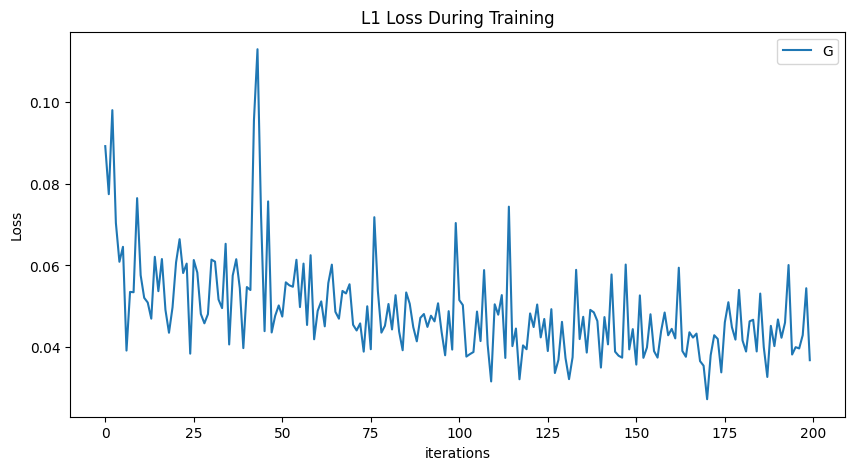

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [11]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

In [12]:
import cv2

# Load best model
checkpoint = torch.load('model_best.pt')
# checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(
    UNet(4)
)

best_model.load_state_dict(checkpoint['model_state_dict'])

root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)


2023-06-15 05:27:28,433 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


Creating buffer for 229 images


tensor(9.9451e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0249, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(250., device='cuda:0')
0.15567741 0.11449765 0.0 1.0
0.14148675 0.104591444 0.0 1.0
0.11178339 0.07664034 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


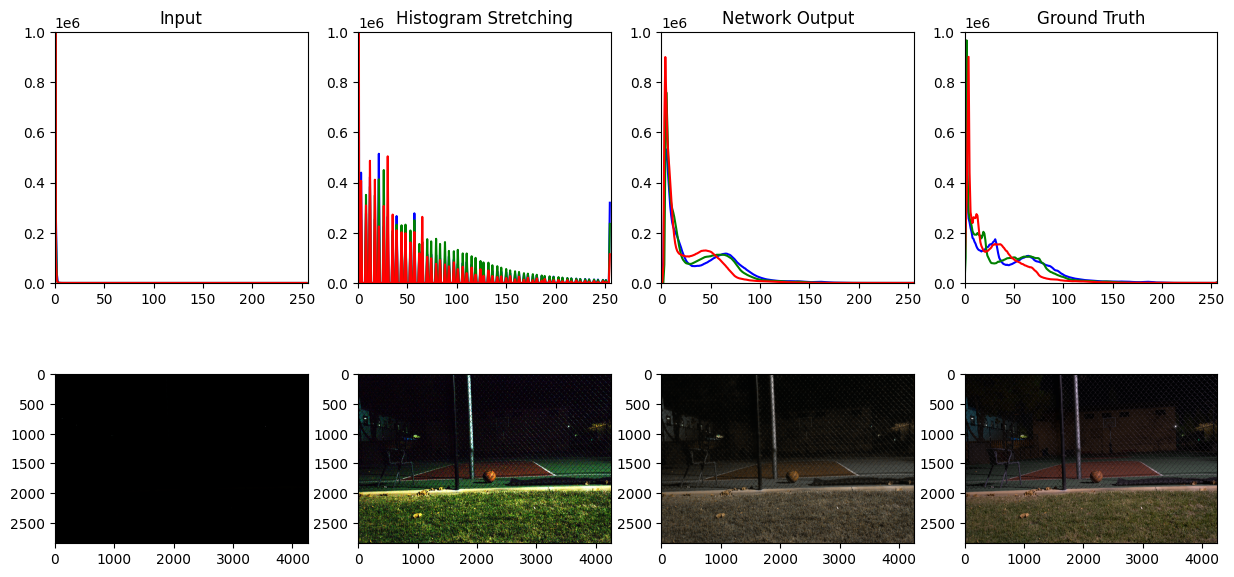

tensor(0.0003, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0300, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(100., device='cuda:0')
0.17743073 0.1428194 0.0 1.0
0.16016835 0.1336175 0.0 1.0
0.12931873 0.10061179 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


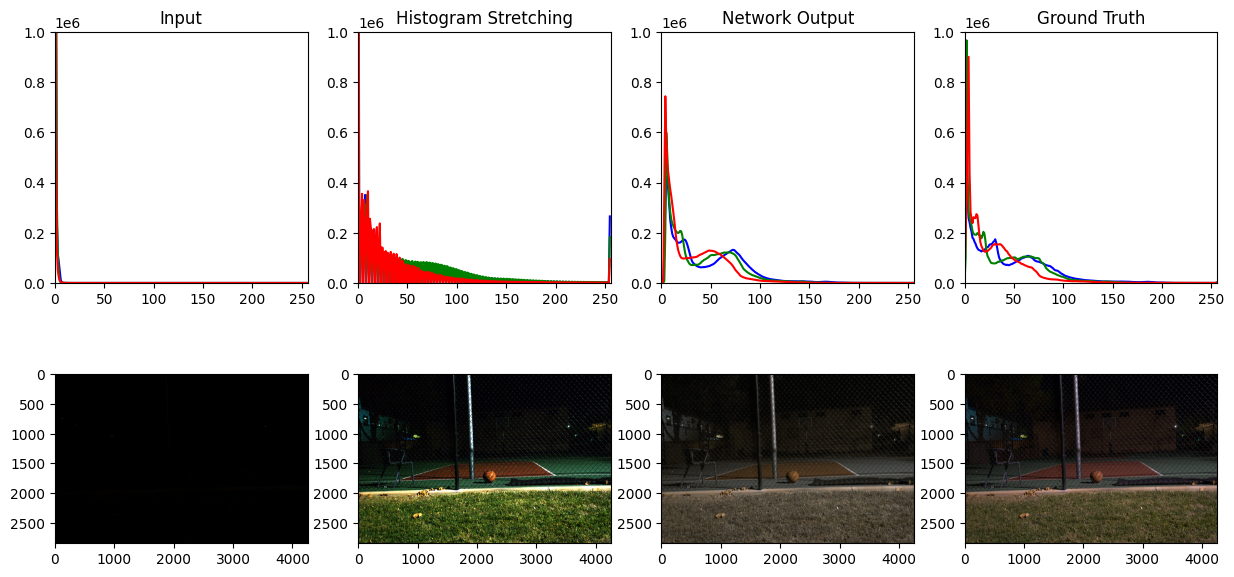

tensor(0.0001, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0129, device='cuda:0')
tensor(0.0317, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(3.2134, device='cuda:0')
0.15130374 0.14551103 0.0 0.9620225
0.1358606 0.12746137 0.0015075887 0.9858324
0.11211488 0.10195667 0.0 0.867625
0.16390072 0.16130312 0.0 1.0
0.13471788 0.12680247 0.0 1.0
0.13667648 0.1257496 0.0 1.0


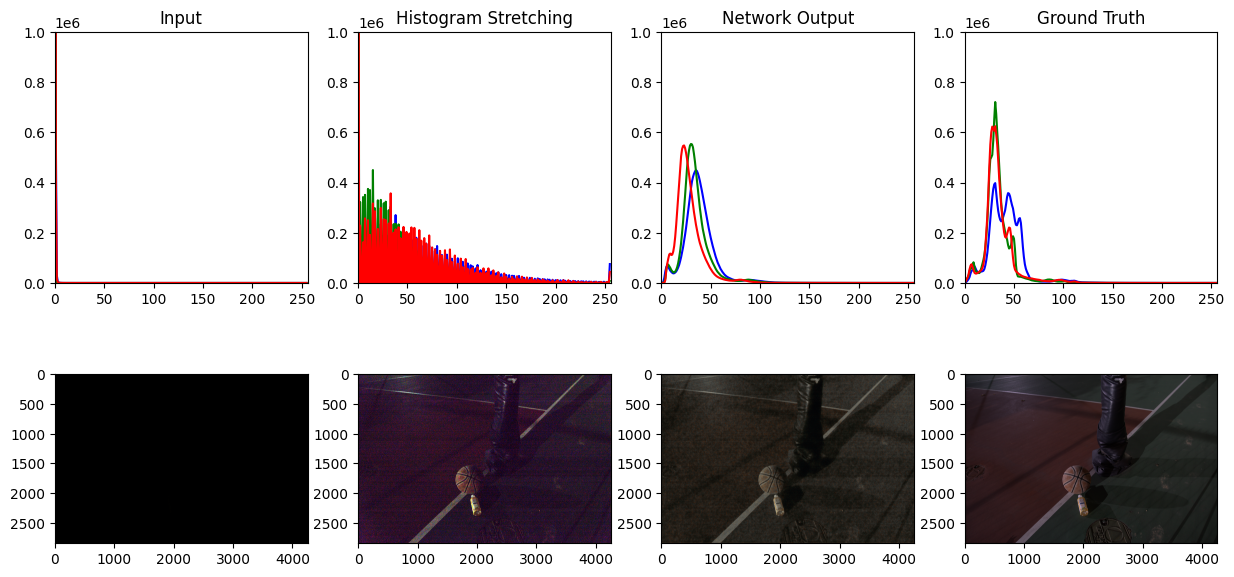

tensor(8.3668e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1387, device='cuda:0')
tensor(0.0209, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(34.6702, device='cuda:0')
0.13659623 0.11949945 0.0 1.0
0.12560624 0.11126082 0.00867406 1.0
0.10280087 0.09191626 0.0 1.0
0.1526067 0.1371023 0.0 1.0
0.13751055 0.12762646 0.0 1.0
0.11115194 0.11282521 0.0 1.0


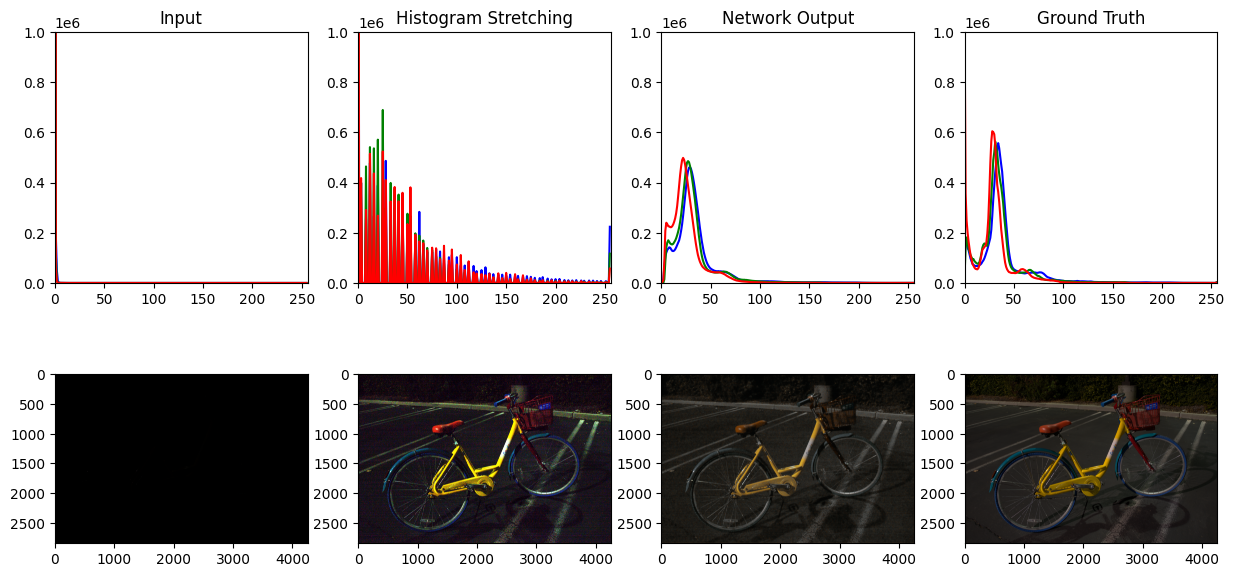

tensor(9.3496e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0594, device='cuda:0')
tensor(0.0234, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(14.8384, device='cuda:0')
0.15881515 0.13152182 0.0030822754 1.0
0.12951635 0.10544525 0.007790708 1.0
0.09947963 0.08011085 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


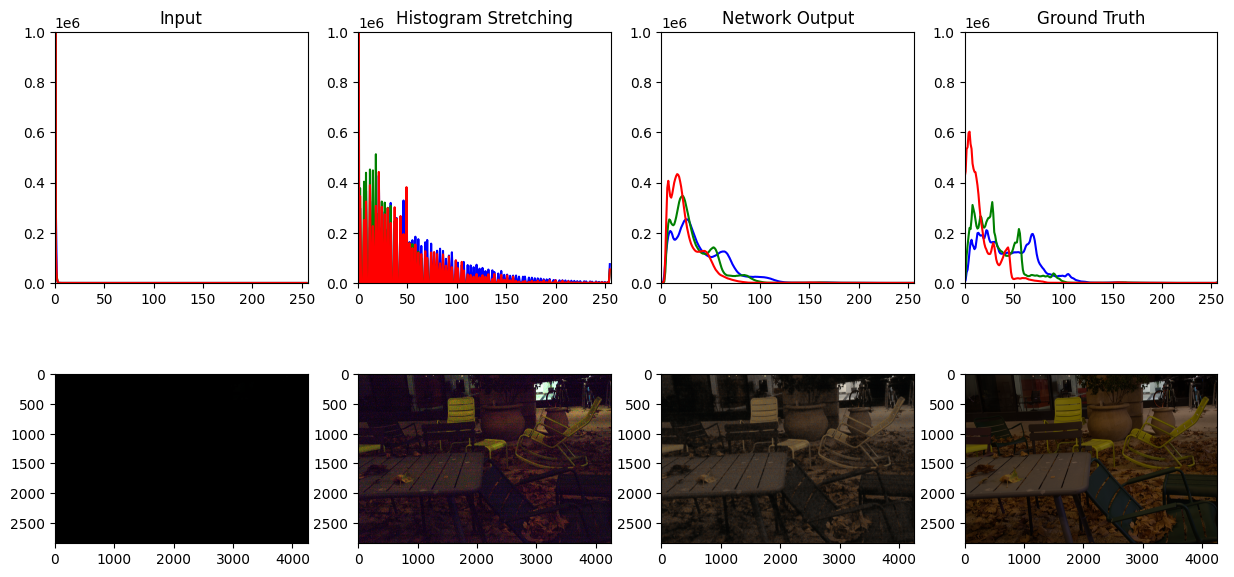

tensor(0.0002, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1466, device='cuda:0')
tensor(0.0224, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(14.6620, device='cuda:0')
0.1779916 0.15132523 0.0038895868 1.0
0.14265178 0.12186075 0.011182396 1.0
0.09509035 0.078889154 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


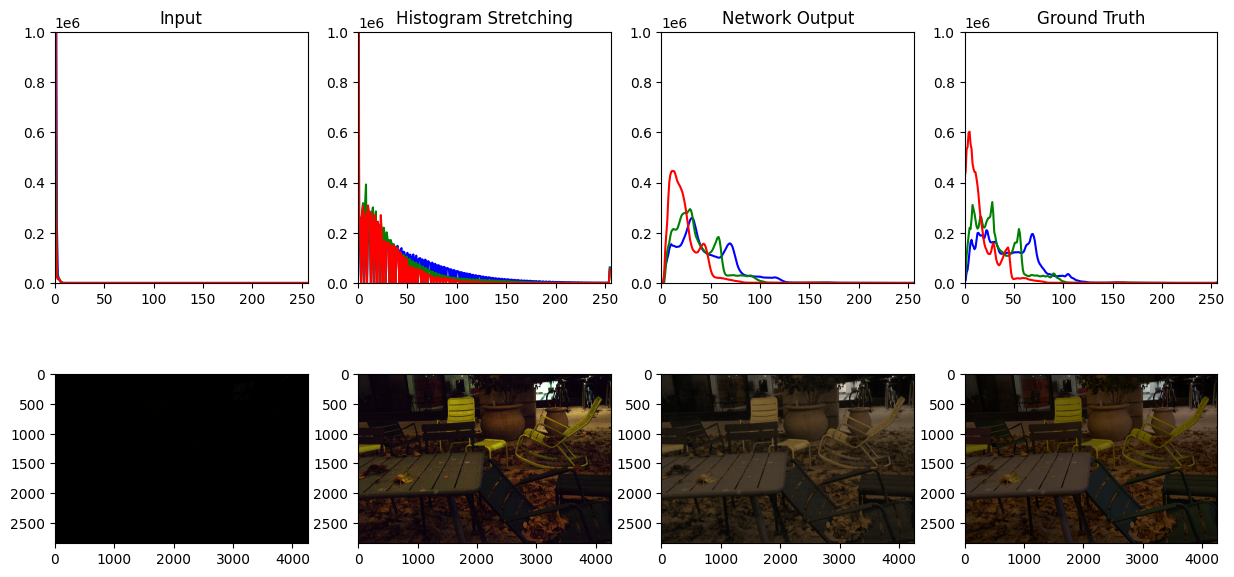

tensor(0.0011, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(0., device='cuda:0') tensor(0.7309, device='cuda:0')
tensor(0.1149, device='cuda:0') tensor(0.0756, device='cuda:0') tensor(0., device='cuda:0') tensor(73.0893, device='cuda:0')
0.4546424 0.4420423 0.0 0.95170665
0.3667856 0.36835414 0.021425344 0.91801435
0.2547909 0.24269834 0.0 0.89481705
0.45840585 0.45607692 0.0 1.0
0.36945933 0.37097734 0.004806592 1.0
0.22926527 0.18481727 0.0 1.0


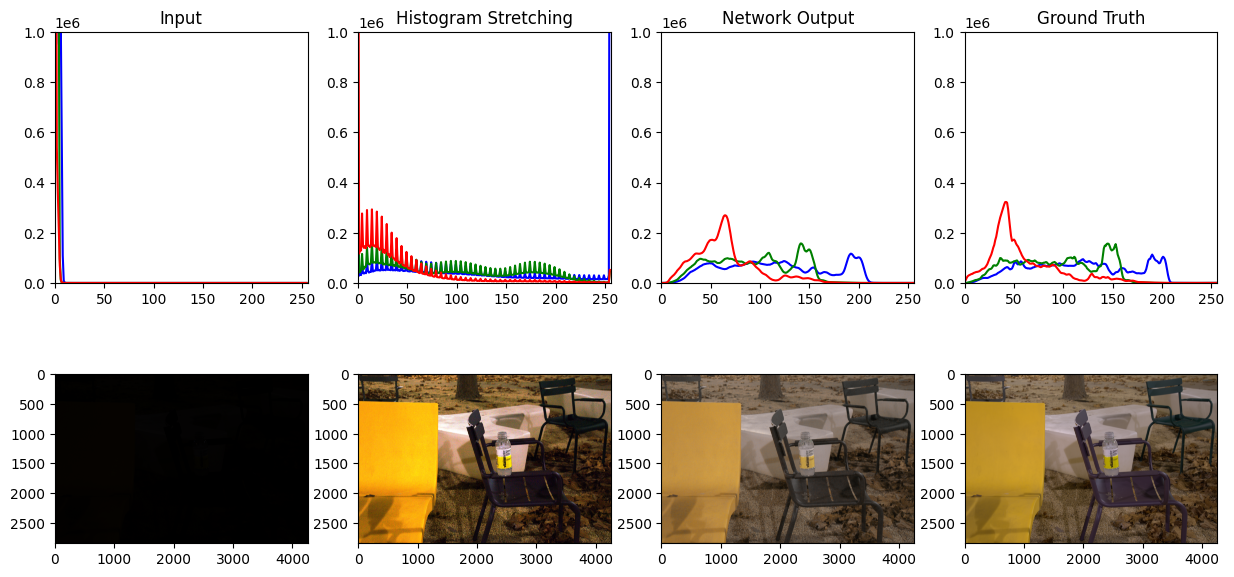

In [13]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    list_samp = [1, 13, 27, 39, 51, 61, 73]
    o = 0
    for batch in sony_test_dataloader:
    # batch = next(iter(sony_test_dataloader))
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch
        o += 1
        if o > list_samp[-1]:
            break
        if o not in list_samp:
            continue
        short_ = short
        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        
        
        output = best_model(short)
        # output = torch.nn.functional.pixel_shuffle(output, 2)

        output = output[0, :, :, :].to('cpu').numpy()
        output = np.minimum(np.maximum(output, 0), 1)
        gt_full = long[0, :, :, :].to('cpu').numpy()
        raw_input = short_raw[0, :, :, :].to('cpu').numpy() / 65535.0
        scale_full = np.float32(short_raw[0, :, :, :].to('cpu').numpy() / 65535.0)
        scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full) 

        print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
        print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
        print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
        print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
        print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
        print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

        output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
        # output = (output-np.min(output))/(np.max(output)-np.min(output))
        gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)
        raw_input = np.minimum(raw_input * 255, 255).astype(np.uint8)
        scale_full = np.minimum(scale_full * 255, 255).astype(np.uint8)

        color = ('b','g','r')
        plt.figure(figsize=(15,15))
        ax = plt.subplot(4,4,1)
        ax.set_title("Input")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([raw_input],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,5)
        plt.imshow(raw_input)

        ax = plt.subplot(4,4,2)
        ax.set_title("Histogram Stretching")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([scale_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,6)
        plt.imshow(scale_full)

        ax = plt.subplot(4,4,3)
        ax.set_title("Network Output")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([output],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,7)
        plt.imshow(output)

        ax = plt.subplot(4,4,4)
        ax.set_title("Ground Truth")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,8)
        plt.imshow(gt_full)
        plt.show()

In [14]:
from ignite.metrics import PSNR, SSIM

def eval_step(engine, batch):
    short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)   
    
    output = best_model(short)
    output = torch.minimum(torch.maximum(output, torch.Tensor([0]).to(idist.device())), torch.Tensor([1]).to(idist.device()))

    return output, long

evaluator = Engine(eval_step)
psnr = PSNR(data_range=1.0)
psnr.attach(evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(evaluator, 'ssim')
ProgressBar().attach(evaluator)

In [15]:
root_dir = "dataset"
sony_val_csv_files = ["dataset/Sony_test_list.txt"]

sony_val_dataset = LabeledDataset(root_dir, *sony_val_csv_files, training=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_val_dataloader = idist.auto_dataloader(sony_val_dataset, batch_size=2, num_workers=8)

Creating buffer for 229 images


2023-06-15 05:29:36,225 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 2, 'num_workers': 8, 'pin_memory': True}


In [16]:
state = evaluator.run(sony_val_dataloader)

In [17]:
print(state.metrics['psnr'])
print(state.metrics['ssim'])

25.447888765786516
0.727370228072074
